# Experiment 1: Occupational Gender Bias in GPT-2 Embedding Space
This notebook analyzes the occupational gender bias in GPT-2 embeddings using cosine similarity, PCA visualization, and WEAT test.

In [2]:
import sys
import os
sys.path.append(os.path.abspath(".."))
sys.path.append(os.path.abspath("./src"))

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import GPT2Tokenizer, GPT2Model

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cpu


In [4]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2').to(DEVICE)
model.eval()
print("GPT-2 model loaded successfully.")

GPT-2 model loaded successfully.


In [5]:
male_stereotype = ['architect', 'chiropractor', 'filmmaker', 'pastor', 'rapper', 'software_engineer']
female_stereotype = ['dietitian', 'interior_designer', 'model', 'nurse', 'paralegal', 'teacher']
neutral = ['accountant', 'attorney', 'dentist', 'journalist', 'painter', 'personal_trainer',
           'photographer', 'physician', 'poet', 'professor', 'dj', 'comedian', 'composer', 'yoga_teacher']

professions = male_stereotype + female_stereotype + neutral
gender_terms = ['he', 'she', 'man', 'woman']

In [6]:
def get_word_embedding(word):
    inputs = tokenizer(word, return_tensors='pt').to(DEVICE)
    with torch.no_grad():
        outputs = model(**inputs).last_hidden_state.mean(dim=1)
    return outputs.squeeze().cpu().numpy()

In [7]:
profession_embeddings = {prof: get_word_embedding(prof) for prof in professions}
gender_embeddings = {term: get_word_embedding(term) for term in gender_terms}
print("Embeddings generated for professions and gender terms.")

Embeddings generated for professions and gender terms.


In [8]:
def manual_cosine_similarity(vec_a, vec_b):
    dot_product = np.dot(vec_a, vec_b)
    norm_a = np.linalg.norm(vec_a)
    norm_b = np.linalg.norm(vec_b)
    if norm_a == 0 or norm_b == 0:
        return 0.0
    return dot_product / (norm_a * norm_b)

In [9]:
similarity_results_manual = {}
for prof, prof_emb in profession_embeddings.items():
    similarities = {}
    for gender_term, gender_emb in gender_embeddings.items():
        sim_score = manual_cosine_similarity(prof_emb, gender_emb)
        similarities[gender_term] = sim_score
    similarity_results_manual[prof] = similarities

In [10]:
os.makedirs('./results', exist_ok=True)
similarity_df_manual = pd.DataFrame(similarity_results_manual).T
similarity_df_manual.to_csv('./results/exp1_similarity_manual.csv')
print("Manual cosine similarity scores calculated and saved.")

Manual cosine similarity scores calculated and saved.


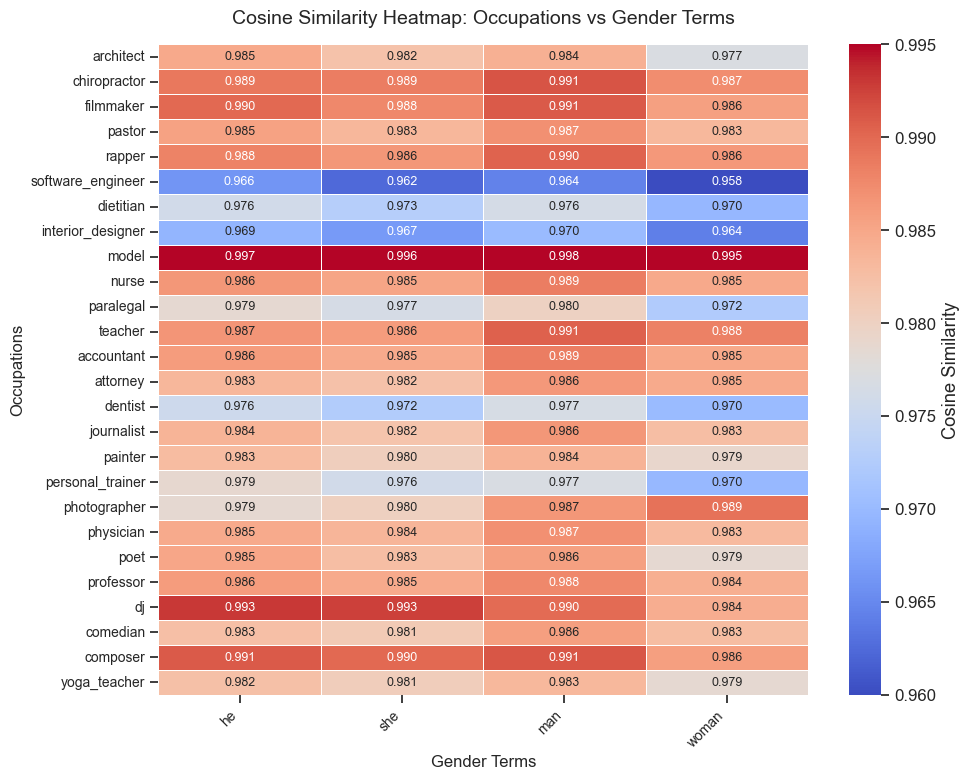

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 8))

# 使用 coolwarm 色谱，更接近原图
cmap = sns.color_palette("coolwarm", as_cmap=True)

sns.set(style="ticks", font_scale=1.1)

ax = sns.heatmap(
    similarity_df_manual,
    annot=True,
    fmt=".3f",
    cmap=cmap,
    vmin=0.96, vmax=0.995,  # 缩窄范围以增强差异感
    cbar_kws={'label': 'Cosine Similarity'},
    linewidths=0.4,
    linecolor='white',
    annot_kws={"size": 9}
)

ax.set_title('Cosine Similarity Heatmap: Occupations vs Gender Terms', fontsize=14, pad=15)
ax.set_xlabel('Gender Terms', fontsize=12)
ax.set_ylabel('Occupations', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig('./results/exp1_similarity_heatmap_recovered.png', dpi=300)
plt.show()


## Gender projection



In [12]:
# 计算性别方向：通过"he"和"she"的向量差来定义
gender_direction = gender_embeddings['man'] - gender_embeddings['woman']

# 计算每个职业在性别方向上的投影
def project_onto_gender_direction(occupation_embedding, gender_direction):
    return np.dot(occupation_embedding, gender_direction) / (np.linalg.norm(gender_direction))

# 计算每个职业的性别投影分数
gender_projection_scores = {}
for prof, prof_emb in profession_embeddings.items():
    projection_score = project_onto_gender_direction(prof_emb, gender_direction)
    gender_projection_scores[prof] = projection_score

# 将结果转换为DataFrame并保存
gender_projection_df = pd.DataFrame.from_dict(gender_projection_scores, orient='index', columns=['Gender Projection'])
gender_projection_df.to_csv('./results/exp1_gender_projection.csv')
print("Gender projection scores calculated and saved.")

Gender projection scores calculated and saved.


In [13]:
print(np.dot(gender_embeddings['man'], gender_direction))
print(np.dot(gender_embeddings['woman'], gender_direction))


50.908592
21.080318


/var/folders/jj/84v_jpsx4rj3__y62xh3klxm0000gn/T/ipykernel_3170/2390316503.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Gender Projection', y=gender_projection_df.index, data=gender_projection_df,


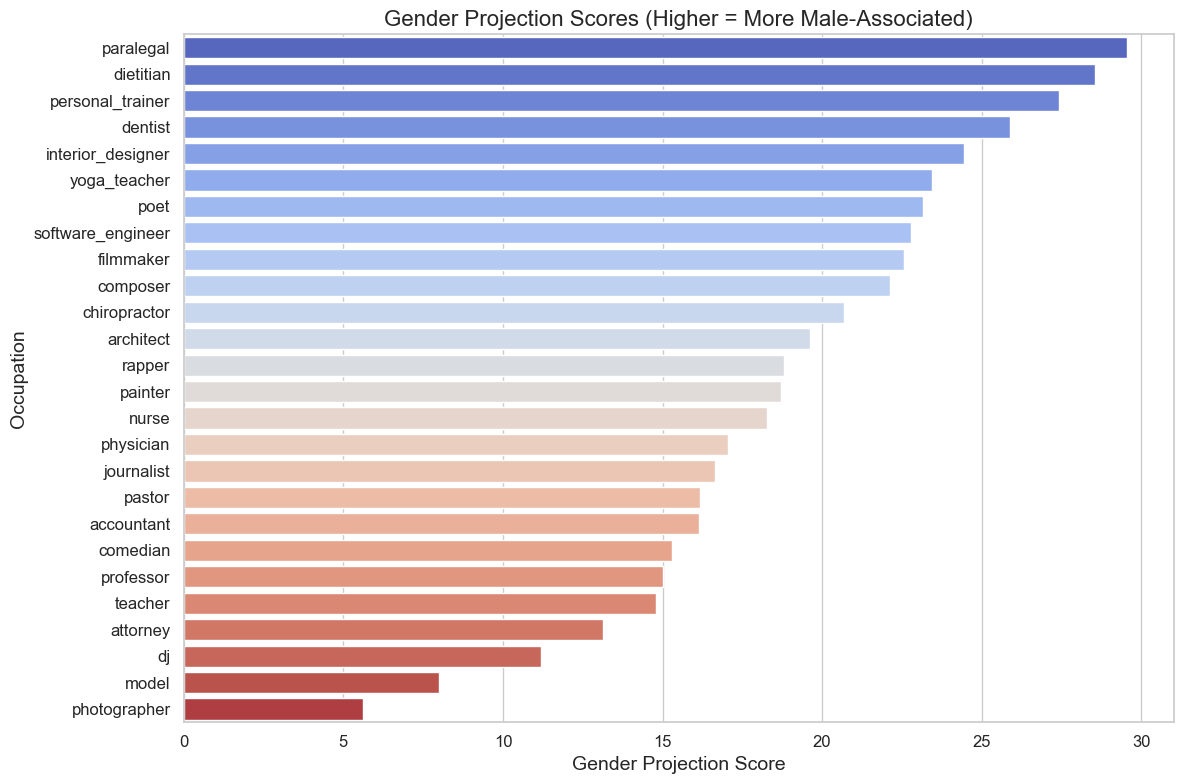

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# 从之前的结果中读取Gender Projection数据
gender_projection_df = pd.read_csv('./results/exp1_gender_projection.csv', index_col=0)
gender_projection_df = gender_projection_df.sort_values('Gender Projection', ascending=False)
# 设置图表的大小和样式
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# 创建条形图
sns.barplot(x='Gender Projection', y=gender_projection_df.index, data=gender_projection_df,
            palette='coolwarm', orient='h')

# 设置标题和标签
plt.title('Gender Projection Scores (Higher = More Male-Associated)', fontsize=16)
plt.xlabel('Gender Projection Score', fontsize=14)
plt.ylabel('Occupation', fontsize=14)

# 调整X轴的显示范围和字体大小
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 确保图形不重叠，显示美观
plt.tight_layout()

# 保存并显示图片
plt.savefig('./results/exp1_gender_projection_barplot.png', dpi=300)
plt.show()
